# Emotion recognition model development

## Imports

In [1]:
!pip install gdown torchinfo 

In [2]:
import collections
import contextlib
import functools
import glob
import IPython
import itertools
import pathlib
import pickle
import time
import os
import random
import requests
import shutil
import warnings
import zipfile

import numpy as np
import pandas as pd
import scipy
import scipy.io
import tqdm.auto as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import PIL

import sklearn
import sklearn.metrics
import sklearn.preprocessing

import torch
import torchvision
import torchinfo

## Setting random states for reproducibility

In [3]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

## Global variables

In [4]:
BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONTEXT_IMAGE_SIZE = 224
BODY_IMAGE_SIZE = 128
CONTEXT_NORM = {"mean": [0.4690646, 0.4407227, 0.40508908], "std": [0.2514227, 0.24312855, 0.24266963]}
BODY_NORM = {"mean": [0.43832874, 0.3964344, 0.3706214], "std": [0.24784276, 0.23621225, 0.2323653]}

## Annotations loading and converting

In [5]:
!gdown https://drive.google.com/uc?id=1HPkjTRC1I9dNSrdarzdybdIM7cKIJPMg

Downloading...
From: https://drive.google.com/uc?id=1HPkjTRC1I9dNSrdarzdybdIM7cKIJPMg
To: /content/Annotations.zip
100% 6.40M/6.40M [00:00<00:00, 138MB/s]


In [6]:
def prepare_annotations(filename):
    if not pathlib.Path("annotations.csv").is_file():
        if "google.colab" in str(IPython.get_ipython()):
            with zipfile.ZipFile(filename, "r") as archive:
                for member in tqdm.tqdm(archive.namelist(), desc="Extracting files", unit="files", unit_scale=False):
                    archive.extract(member, os.getcwd())
        else:
            if os.path.isfile(filename):
                shutil.rmtree("Annotations", ignore_errors=True) # clear out old data
                with zipfile.ZipFile(filename, "r") as archive:
                    for member in tqdm.tqdm(archive.namelist(), desc="Extracting files", unit="files", unit_scale=False):
                        archive.extract(member, os.getcwd())
        shutil.move("Annotations/Annotations.mat", ".")
        shutil.rmtree("Annotations", ignore_errors=True)
        shutil.rmtree("__MACOSX", ignore_errors=True)
        with contextlib.suppress(FileNotFoundError):
            os.remove(filename)
    mat_data = scipy.io.loadmat("Annotations.mat")
    return mat_data["train"][0]

In [7]:
mat_data = prepare_annotations("Annotations.zip")

Extracting files:   0%|          | 0/19 [00:00<?, ?files/s]

In [8]:
def set_imsize(image_size):
    im_size = []
    image_size = np.array(image_size).flatten().tolist()[0]
    row = np.array(image_size[0]).flatten().tolist()[0]
    col = np.array(image_size[1]).flatten().tolist()[0]
    im_size.append(row)
    im_size.append(col)
    return im_size

def validate_bbox(bbox, im_size):
        x1, y1, x2, y2 = bbox
        x1 = min(im_size[0], max(0, x1))
        x2 = min(im_size[0], max(0, x2))
        y1 = min(im_size[1], max(0, y1))
        y2 = min(im_size[1], max(0, y2))
        return [int(x1), int(y1), int(x2), int(y2)]

def set_bbox(person_bbox, im_size):
    return validate_bbox(np.array(person_bbox).flatten().tolist(), im_size)

def set_emotions(person_emotions):
    cat = np.array(person_emotions).flatten().tolist()
    if not cat:
        return
    cat = np.array(cat[0]).flatten().tolist()
    return [np.array(c).flatten().tolist()[0] for c in cat]

def set_vad_scores(person_vad):
    cont = np.array(person_vad).flatten().tolist()
    if not cont:
        return
    return [np.array(c).flatten().tolist()[0] for c in cont[0]]

def convert_annotations(mat_train):
    rows = list()
    for e in tqdm.tqdm(mat_train, desc="Converting annotations", unit="files", unit_scale=False):
        for person in e[4][0]:
            row = {
                "Filename": e[0][0],
                "Folder": e[1][0],
                "Gender": person[3][0],
                "Age": person[4][0]
            }
            row["Image Size"] = set_imsize(e[2])
            row["Bounding Box"] = set_bbox(person[0], row["Image Size"])
            row["Emotions"] = set_emotions(person[1])
            row["VAD Scores"] = set_vad_scores(person[2])
            if pd.isnull(np.array(row["Emotions"])).any():
                row["Emotions"] = None
            if pd.isnull(np.array(row["VAD Scores"])).any():
                row["VAD Scores"] = None
            rows.append(row)
    df = pd.DataFrame.from_records(rows)
    df.dropna(inplace=True)
    df.to_csv(f"annotations.csv", index=False)
    with contextlib.suppress(FileNotFoundError):
        os.remove("Annotations.mat")

In [9]:
convert_annotations(mat_data)

Converting annotations:   0%|          | 0/17077 [00:00<?, ?files/s]

## Dataset loading, preprocessing and splitting

In [10]:
class EmoticDataset(torch.utils.data.Dataset):
    def __init__(self, dir, annotations_fname):
        super().__init__()
        self.dir = dir
        self.annotations = pd.read_csv(annotations_fname)
        self.annotations["Image Size"] = self.annotations["Image Size"].apply(eval)
        self.annotations["Bounding Box"] = self.annotations["Bounding Box"].apply(eval)
        self.annotations["Emotions"] = self.annotations["Emotions"].apply(eval)
        self.annotations["VAD Scores"] = self.annotations["VAD Scores"].apply(eval)
        self.mlb = sklearn.preprocessing.MultiLabelBinarizer()
        self.mlb.fit(self.annotations["Emotions"].to_numpy())
        self.context_transforms = torchvision.transforms.Compose([
            torchvision.transforms.PILToTensor(),
            torchvision.transforms.ConvertImageDtype(torch.float32),
            torchvision.transforms.Resize(CONTEXT_IMAGE_SIZE),
            torchvision.transforms.Normalize(CONTEXT_NORM["mean"], CONTEXT_NORM["std"])
        ])
        self.body_transforms = torchvision.transforms.Compose([
            torchvision.transforms.PILToTensor(),
            torchvision.transforms.ConvertImageDtype(torch.float32),
            torchvision.transforms.Resize(BODY_IMAGE_SIZE),
            torchvision.transforms.Normalize(BODY_NORM["mean"], BODY_NORM["std"])
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        row = self.annotations.loc[index]
        context = PIL.Image.open(pathlib.Path(self.dir) / row["Folder"] / row["Filename"]).convert("RGB")
        bbox = row["Bounding Box"]
        body = context.crop((bbox[0], bbox[1], bbox[2], bbox[3])).resize((BODY_IMAGE_SIZE, BODY_IMAGE_SIZE))
        context = context.resize((CONTEXT_IMAGE_SIZE, CONTEXT_IMAGE_SIZE))
        emotions = self.mlb.transform([row["Emotions"]])
        vad_scores = row["VAD Scores"]
        return self.context_transforms(context), self.body_transforms(body), torch.tensor(emotions).squeeze(0), torch.tensor(vad_scores) / 10.0

    def get_emotion_name(self, output):
        return self.mlb.inverse_transform(output)

In [11]:
!gdown https://drive.google.com/uc?id=16V-PJBpdFakpzYTba3sdg_Fg3z9YED3C

Downloading...
From: https://drive.google.com/uc?id=16V-PJBpdFakpzYTba3sdg_Fg3z9YED3C
To: /content/emotic.zip
100% 3.60G/3.60G [00:17<00:00, 205MB/s]


In [12]:
def prepare_dataset(filename):
    if not pathlib.Path("emotic").is_dir():
        if "google.colab" in str(IPython.get_ipython()):
                with zipfile.ZipFile(filename, "r") as archive:
                    for member in tqdm.tqdm(archive.namelist(), desc="Extracting files", unit="files", unit_scale=False):
                        archive.extract(member, os.getcwd())
        else:
            if os.path.isfile(filename):
                shutil.rmtree("emotic", ignore_errors=True) # clear out old data
                with zipfile.ZipFile(filename, "r") as archive:
                    for member in tqdm.tqdm(archive.namelist(), desc="Extracting files", unit="files", unit_scale=False):
                        archive.extract(member, os.getcwd())
        # I hate MacOS
        with contextlib.suppress(FileNotFoundError):
            for path in pathlib.Path("emotic").rglob("*.*"):
                if not str(path).endswith(".jpg"):
                    os.remove(str(path))
    if not pathlib.Path("annotations.csv").is_file():
        raise ValueError("No annotations file detected, cannot proceed")
    return EmoticDataset("emotic", "annotations.csv")

In [13]:
dataset = prepare_dataset("emotic.zip")

Extracting files:   0%|          | 0/23198 [00:00<?, ?files/s]

In [14]:
trainset, remains = torch.utils.data.random_split(dataset, 
                                                  [int(0.7 * len(dataset)), len(dataset) - int(0.7 * len(dataset))],
                                                  torch.Generator().manual_seed(RANDOM_STATE))

In [15]:
valset, testset = torch.utils.data.random_split(remains, 
                                                [len(remains) // 2, len(remains) - len(remains) // 2],
                                                torch.Generator().manual_seed(RANDOM_STATE))

## Preparing Dataloaders

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True, drop_last=True)
valloader = torch.utils.data.DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, BATCH_SIZE, shuffle=False, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True, drop_last=True)

## Selecting optimal "tail" CNN (based on inference time)

In [17]:
mobilenet = torchvision.models.mobilenet.mobilenet_v3_small(pretrained=True).to(DEVICE)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [18]:
torchinfo.summary(mobilenet, (BATCH_SIZE, 3, CONTEXT_IMAGE_SIZE, CONTEXT_IMAGE_SIZE))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        --                        --
├─Sequential: 1-1                                  [256, 576, 7, 7]          --
│    └─ConvNormActivation: 2-1                     [256, 16, 112, 112]       --
│    │    └─Conv2d: 3-1                            [256, 16, 112, 112]       432
│    │    └─BatchNorm2d: 3-2                       [256, 16, 112, 112]       32
│    │    └─Hardswish: 3-3                         [256, 16, 112, 112]       --
│    └─InvertedResidual: 2-2                       [256, 16, 56, 56]         --
│    │    └─Sequential: 3-4                        [256, 16, 56, 56]         744
│    └─InvertedResidual: 2-3                       [256, 24, 28, 28]         --
│    │    └─Sequential: 3-5                        [256, 24, 28, 28]         3,864
│    └─InvertedResidual: 2-4                       [256, 24, 28, 28]         --
│    │    └─Sequential: 3-6   

In [19]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
torchinfo.summary(resnet18, (BATCH_SIZE, 3, CONTEXT_IMAGE_SIZE, CONTEXT_IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [256, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [256, 64, 112, 112]       128
├─ReLU: 1-3                              [256, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [256, 64, 56, 56]         --
├─Sequential: 1-5                        [256, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [256, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [256, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [256, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [256, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [256, 64, 56, 56]         --
│

In [21]:
#effnet = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT).to(DEVICE)

In [22]:
#torchinfo.summary(effnet, (BATCH_SIZE, 3, CONTEXT_IMAGE_SIZE, CONTEXT_IMAGE_SIZE))

In [23]:
def inference_time(model):
    dummy_input = torch.randn(1, 3, CONTEXT_IMAGE_SIZE, CONTEXT_IMAGE_SIZE, dtype=torch.float).to(DEVICE)
    start, end = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 300
    timings = np.zeros((repetitions, 1))
    # GPU warmup
    for _ in range(10):
        _ = model(dummy_input)
    # Performance measuring
    with torch.no_grad():
        for rep in range(repetitions):
            start.record()
            _ = model(dummy_input)
            end.record()
            torch.cuda.synchronize()
            curr_time = start.elapsed_time(end)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    return mean_syn, std_syn

In [24]:
mean_syn_mobnet, std_syn_mobnet = inference_time(mobilenet)
print(f"Mean inference time for MobileNetV2 (with sync): {mean_syn_mobnet}, stddev: {std_syn_mobnet}")
mean_syn_resnet, std_syn_resnet = inference_time(resnet18)
print(f"Mean inference time for ResNet18 (with sync): {mean_syn_resnet}, stddev: {std_syn_resnet}")

Mean inference time for MobileNetV2 (with sync): 8.66685073852539, stddev: 1.2330857784960745
Mean inference time for ResNet18 (with sync): 4.774470500946045, stddev: 0.6755903223565024


*Will check out ResNet performance in pre-deployment test, if the model turns out to be too large, will switch to MobileNet*

In [25]:
mobilenet, resnet18 = mobilenet.cpu(), resnet18.cpu()
del mobilenet, resnet18
torch.cuda.synchronize()
torch.cuda.empty_cache()

## Model architecture definition and preloading

In [26]:
def partialclass(cls, *args, **kwargs):
    class NewCls(cls):
        __init__ = functools.partialmethod(cls.__init__, *args, **kwargs)

    return NewCls

In [27]:
def download_file(url, dest):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(dest, 'wb') as f:
            for chunk in tqdm.tqdm(r.iter_content(chunk_size=8192), desc="Downloading"):
                #if chunk: 
                f.write(chunk)
    return

In [28]:
class EmoticNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._load_body_tail()
        self._load_context_tail()
        self.fusion_block = torch.nn.Sequential(collections.OrderedDict([
            ("fusion_fc", torch.nn.Linear(self.context_out_size+ self.body_out_size, 256)),
            ("fusion_batchnorm", torch.nn.BatchNorm1d(256)),
            ("fusion_act", torch.nn.ReLU(inplace=True)),
            ("fusion_dropout", torch.nn.Dropout(p=0.5)),
        ]))
        self.emotion_dense = torch.nn.Linear(256, 26)
        self.vad_dense = torch.nn.Linear(256, 3)

        for p in self.parameters():
            p.requires_grad_ = True

    def _load_context_tail(self):
        pickle.load = functools.partial(pickle.load, encoding="latin1")
        unpickler_orig = pickle.Unpickler
        pickle.Unpickler = partialclass(pickle.Unpickler, encoding="latin1")
        checkpoint_file = pathlib.Path(torch.hub.get_dir()) / "checkpoints" / "resnet18_places365.pth.tar"
        if not checkpoint_file.is_file():
            download_file("http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar", checkpoint_file)
        context_tail = torch.load(checkpoint_file, map_location=lambda storage, loc: storage, pickle_module=pickle)
        torch.save(context_tail, pathlib.Path(torch.hub.get_dir()) / "checkpoints" / "resnet.pth.tar")
        context_tail = torchvision.models.resnet18(num_classes=365)
        checkpoint = torch.load(pathlib.Path(torch.hub.get_dir()) / "checkpoints" / "resnet.pth.tar", map_location=lambda storage, loc: storage)
        state_dict = {str.replace(k, "module.", ""): v for k, v in checkpoint["state_dict"].items()}
        context_tail.load_state_dict(state_dict)
        context_tail.eval()
        self.context_out_size = list(context_tail.children())[-1].in_features
        context_tail = torch.nn.Sequential(*(list(context_tail.children())[:-1]))
        context_tail.add_module("flatten", torch.nn.Flatten())
        self.context_tail = context_tail
        pickle.load = pickle.load.func
        pickle.Unpickler = unpickler_orig

    def _load_body_tail(self):
        body_tail = torchvision.models.resnet18(pretrained=True)
        body_tail = body_tail.cpu()
        self.body_out_size = list(body_tail.children())[-1].in_features
        body_tail = torch.nn.Sequential(*(list(body_tail.children())[:-1]))
        body_tail.add_module("flatten", torch.nn.Flatten())
        self.body_tail = body_tail

    def _apply(self, fn):
        # required to move tails to the same device as the fusion block and heads
        super()._apply(fn)
        self.context_tail._apply(fn)
        self.body_tail._apply(fn)
        return self

    def forward(self, context, body):
        features_context = self.context_tail(context)
        features_body = self.body_tail(body)
        fused = torch.cat((features_context, features_body), 1)
        fused_out = self.fusion_block(fused)
        emotions = self.emotion_dense(fused_out)
        vad = self.vad_dense(fused_out)
        return emotions, vad

In [29]:
model = EmoticNet().to(DEVICE)

Downloading: 0it [00:00, ?it/s]

In [30]:
torchinfo.summary(model, ((BATCH_SIZE, 3, CONTEXT_IMAGE_SIZE, CONTEXT_IMAGE_SIZE), (BATCH_SIZE, 3, BODY_IMAGE_SIZE, BODY_IMAGE_SIZE)))

Layer (type:depth-idx)                        Output Shape              Param #
EmoticNet                                     --                        --
├─Sequential: 1-1                             [256, 512]                --
│    └─Conv2d: 2-1                            [256, 64, 112, 112]       9,408
│    └─BatchNorm2d: 2-2                       [256, 64, 112, 112]       128
│    └─ReLU: 2-3                              [256, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [256, 64, 56, 56]         --
│    └─Sequential: 2-5                        [256, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [256, 64, 56, 56]         73,984
│    │    └─BasicBlock: 3-2                   [256, 64, 56, 56]         73,984
│    └─Sequential: 2-6                        [256, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [256, 128, 28, 28]        230,144
│    │    └─BasicBlock: 3-4                   [256, 128, 28, 28]        295,42

In [31]:
!nvidia-smi

Sun May 22 11:19:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    68W /  70W |   4028MiB / 15109MiB |     81%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loss definition

In [32]:
class EmoticLoss(torch.nn.Module):
    def __init__(self, weight_type="mean", margin=1, ratio=0.5, shift=1.2, smooth=1e-4, vad_loss_type="sl1", device=torch.device("cpu")):
        super().__init__()
        self.weight_type = weight_type
        self.margin = margin
        self.ratio = ratio
        self.shift = shift
        self.smooth = smooth
        self.device = device
        self.vad_loss_type = vad_loss_type
        if self.weight_type == "mean":
            self.weights = torch.ones((1, 26)) / 26.0
            self.weights = self.weights.to(self.device)
        elif self.weight_type == "static":
            self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
                                              0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
                                              0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
            self.weights = self.weights.to(self.device)

    def _create_dynamic_weights(self, target):
        target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
        weights = torch.zeros((1, 26))
        weights[target_stats != 0] = 1.0 / torch.log(target_stats[target_stats != 0].data + self.shift)
        weights[target_stats == 0] = self.smooth
        return weights

    def _emotions_loss(self, pred, target):
        if self.weight_type == "dynamic":
            self.weights = self._create_dynamic_weights(target)
            self.weights = self.weights.to(self.device)
        return (((pred - target) ** 2) * self.weights).sum()

    def _vad_loss_sl1(self, pred, target):
        mae = torch.abs(pred - target)
        loss = 0.5 * (mae ** 2)
        loss[(mae > self.margin)] = mae[(mae > self.margin)] - 0.5
        return loss.sum()

    def _vad_loss_l2(self, pred, target):
        mae = torch.abs(pred - target)
        loss = mae ** 2
        loss[(mae < self.margin)] = 0.0
        return loss.sum()

    
    def forward(self, pred_emotions, target_emotions, pred_vad, target_vad):
        emotions_loss = self._emotions_loss(pred_emotions, target_emotions)
        if self.vad_loss_type == "sl1":
            vad_loss = self._vad_loss_sl1(pred_vad, target_vad)
        else:
            vad_loss = self._vad_loss_l2(pred_vad, target_vad)
        return emotions_loss * self.ratio + vad_loss * (1 - self.ratio)

## Training loop

In [33]:
def fit_epoch(model, loader, optimizer, criterion, epoch, epochs, device=DEVICE):
    losses = []
    model.train()
    for context, body, emotions, vad_scores in tqdm.tqdm(loader, desc=f"Training, epoch {epoch + 1} / {epochs}", unit="batches", unit_scale=False):
        try:
            context, body, emotions, vad_scores = context.to(device), body.to(device), emotions.to(device), vad_scores.to(device)
            optimizer.zero_grad()
            pred_emotions, pred_vad = model(context, body)
            loss = criterion(pred_emotions, emotions, pred_vad * 10, vad_scores * 10)
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            pred_emotions, pred_vad = pred_emotions.cpu(), pred_vad.cpu()
            del pred_emotions, pred_vad
        finally:
            context, body, emotions, vad_scores = context.cpu(), body.cpu(), emotions.cpu(), vad_scores.cpu()
            del context, body, emotions, vad_scores
    
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    return np.mean(losses)

def eval_epoch(model, loader, criterion, epoch, epochs, device=DEVICE):
    losses = []
    scores = []
    model.eval()
    for context, body, emotions, vad_scores in tqdm.tqdm(loader, desc=f"Validating, epoch {epoch + 1} / {epochs}", unit="batches", unit_scale=False):
        try:
            context, body, emotions, vad_scores = context.to(device), body.to(device), emotions.to(device), vad_scores.to(device)
            with torch.no_grad():
                pred_emotions, pred_vad = model(context, body)
                loss = criterion(pred_emotions, emotions, pred_vad * 10, vad_scores * 10)
            losses.append(loss.item())
            pred_emotions, pred_vad = pred_emotions.cpu(), pred_vad.cpu()
            emotion_jaccard = sklearn.metrics.jaccard_score(emotions.cpu().numpy(), (pred_emotions > 0.5).to(int), average="samples")
            scores.append(emotion_jaccard)
            del pred_emotions, pred_vad
        finally:
            context, body, emotions, vad_scores = context.cpu(), body.cpu(), emotions.cpu(), vad_scores.cpu()
            del context, body, emotions, vad_scores

    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    return np.mean(losses), np.mean(scores)

def fit(model, train_loader, val_loader, optimizer, criterion, epochs, scheduler=None, device=DEVICE, start_epoch=0):
    history = []
    start_time = time.time()
    with tqdm.tqdm(desc="Epoch", total=epochs, unit="epoch", unit_scale=False) as pbar:
        for epoch in range(start_epoch, epochs):
            try:
                train_loss = fit_epoch(model, train_loader, optimizer, criterion, epoch, epochs, device)
                val_loss, scores = eval_epoch(model, val_loader, criterion, epoch, epochs, device)
                IPython.display.clear_output(wait=True)

                history.append((train_loss, val_loss, scores, optimizer.param_groups[0]["lr"]))

                if scheduler is not None:
                    scheduler.step()

                show_train_pics(model, val_loader, epoch, history[-1], device)

                pbar.update(1)
                pbar.refresh()

            except KeyboardInterrupt as stop:
                tqdm.tqdm.write(f"Training interrupted at epoch {epoch + 1}, returning history")
                return history

    end_time = time.time()
    train_time = end_time - start_time
    tqdm.tqdm.write(f"Training time: {train_time: 0.1f}")

    return history

def denormalize_image(image, norm_params):
    return image * norm_params["std"][0] + norm_params["mean"][0]

def show_train_pics(model, val_loader, epoch, epoch_stats, device=DEVICE, sample_size=4):
    plt.figure(figsize=(20, 20))
    header = "Validation results on epoch {ep:03d}\n\
    Train loss: {t_loss: 0.4f}, validation loss: {v_loss: 0.4f}, Jaccard score: {j_score: 0.4f}"
    contexts, bodies, _, _ = next(iter(val_loader))
    contexts, bodies = contexts[:sample_size], bodies[:sample_size]
    contexts, bodies = contexts.to(device), bodies.to(device)
    with torch.no_grad():
        emotions, vad_scores = model(contexts, bodies)
        emotion_labels = dataset.get_emotion_name(emotions.gt(torch.full_like(emotions, 0.5)).cpu())
        vad_scores *= 10
    for i in range(sample_size):
        plt.subplot(sample_size, 1, i + 1)
        plt.imshow(np.clip(denormalize_image(bodies[i].cpu(), BODY_NORM).permute(1, 2, 0).numpy(), 0, 1))
        plt.title(f"Emotions: {emotion_labels[i]}, VAD scores: {vad_scores[i].cpu().tolist()}")
        plt.axis("off")
    plt.suptitle(header.format(ep=epoch + 1, t_loss=epoch_stats[0], v_loss=epoch_stats[1], j_score=epoch_stats[2]))
    plt.show()
    contexts, bodies, emotions, vad_scores = contexts.cpu(), bodies.cpu(), emotions.cpu(), vad_scores.cpu()
    del contexts, bodies, emotions, vad_scores
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

In [34]:
def plot_loss(history):
  loss, val_loss, _, _ = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(loss, label="Train loss")
  plt.plot(val_loss, label="Validation loss")
  plt.legend(loc="best")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

def plot_metrics(history):
  _, _, val_metric, _ = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(val_metric, label="Jaccard score")
  plt.legend(loc="best")
  plt.xlabel("Epochs")
  plt.ylabel("Score")
  plt.show()

def plot_learn_rate(history):
  _, _, _, learn_rate = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(learn_rate, label="Learn rate")
  plt.legend(loc="best")
  plt.xlabel("Epochs")
  plt.ylabel("Learn rate")
  plt.show()

In [35]:
def load_model(path, model_arch, optim_class, optim_kwargs):
  model = model_arch()
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint["model_state_dict"])
  optim = optim_class(model.parameters(), **optim_kwargs)
  optim.load_state_dict(checkpoint["optim_state_dict"])
  epoch = checkpoint["epoch"]
  loss = checkpoint["loss"]
  history = checkpoint["history"]
  model.eval()
  return model, optim, epoch, loss, history

In [36]:
def save_history(path, history):
  with open(path, "wb") as f:
    pickle.dump(history, f)

In [37]:
def load_history(path):
  with open(path, "rb") as f:
    history = pickle.load(f)
  
  return history

## Training the model

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = EmoticLoss(device=DEVICE)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f24050a30e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f24050a30e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

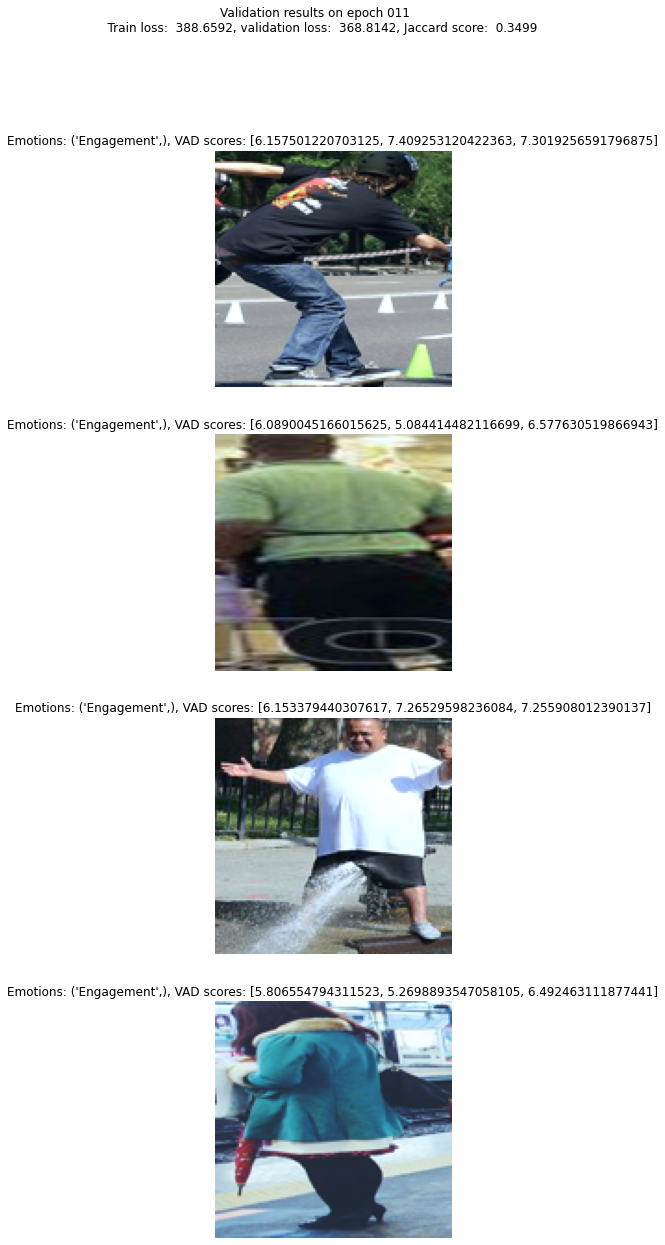

Training, epoch 12 / 50:   0%|          | 0/63 [00:00<?, ?batches/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Validating, epoch 12 / 50:   0%|          | 0/13 [00:00<?, ?batches/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f24050a30e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f24050a30e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Training interrupted at epoch 12, returning history


In [39]:
history = fit(model, trainloader, valloader, optimizer, criterion, 50, scheduler=scheduler, device=DEVICE)

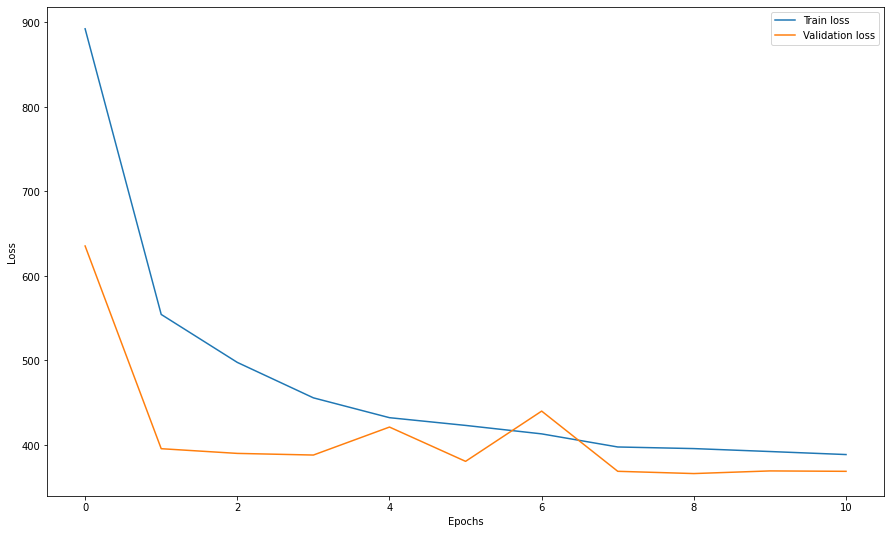

In [40]:
plot_loss(history)

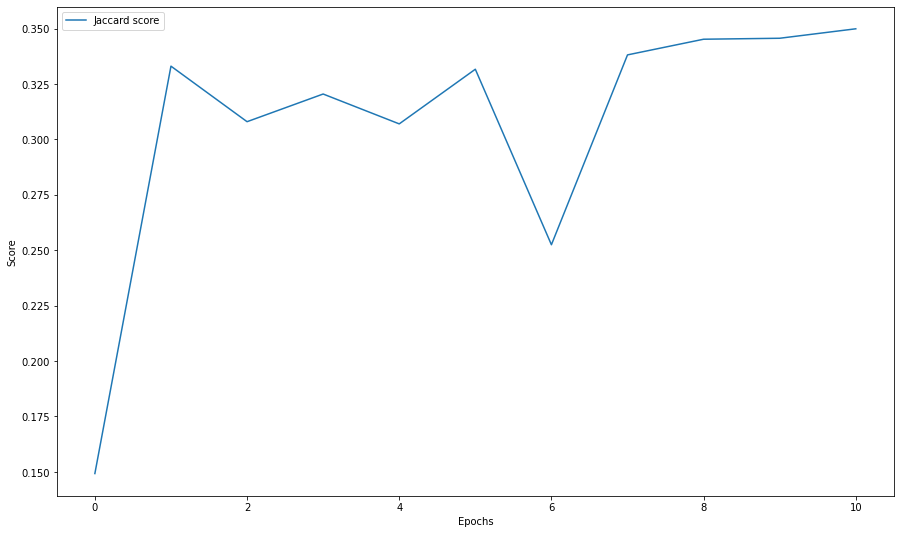

In [41]:
plot_metrics(history)

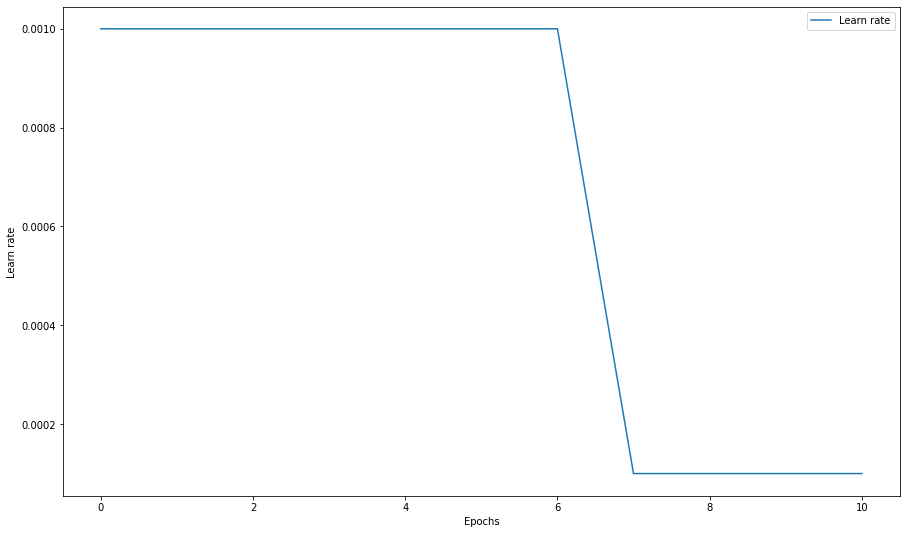

In [42]:
plot_learn_rate(history)

In [44]:
torch.save(model, "model.tar")